In [4]:
EPSILONS = [50, 100, 1000, 10000]
MAX_ITER = 5000

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append('..')

In [7]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import tqdm

from scipy.stats import entropy
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import train_test_split

from trickster.domain.wfp import load_data, extract

/home/bogdan/Workspace/trickster/venv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
import plot_params

## Trace length analysis

In [9]:
X, y = load_data(path='../data/knndata/', verbose=False)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [11]:
with open('../out/models/model_full_lr_cumul.pkl', 'rb') as f:
    lr_model = pickle.load(f)
    
with open('../out/models/model_full_svmrbf_cumul.pkl', 'rb') as f:
    svm_model = pickle.load(f)

In [12]:
trace_len_df = pd.DataFrame()

for trace, label in tqdm.tqdm_notebook(list(zip(X_test, y_test))):
    cumul_feature_vec = extract(trace)
    trace_len_df = trace_len_df.append(
        {
            'tracelen': float(len(trace)),
            'label': float(label),
            'lrpred': float(lr_model.predict([cumul_feature_vec])[0]),
            'svmpred': float(svm_model.predict([cumul_feature_vec])[0]),
        },
        ignore_index=True
    )
    
trace_len_df.head()

,label,lrpred,svmpred,tracelen
0,1.0,0.0,1.0,76.0
1,0.0,0.0,0.0,64.0
2,1.0,0.0,1.0,123.0
3,1.0,1.0,1.0,2659.0
4,0.0,0.0,0.0,986.0


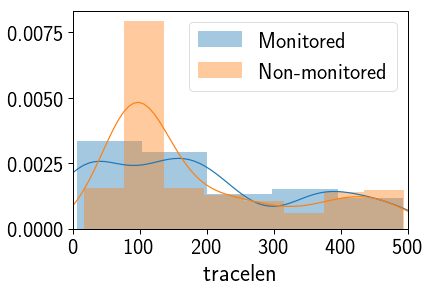

In [13]:
fig, ax = plt.subplots()

sns.distplot(trace_len_df.query('label == 0 and tracelen <= 500').tracelen,
             label='Monitored',
             ax=ax)
sns.distplot(trace_len_df.query('label == 1 and tracelen <= 500').tracelen,
             label='Non-monitored',
             ax=ax)

ax.set_xlim(0, 500)
ax.legend()

## Visualizing adversarial traces

In [14]:
results_pickle_names = [
    '../out/reports/results_full_eps_{}_tracelen_500_iter_5000.pkl'.format(eps)
    for eps in EPSILONS
]
adv_results = [pickle.load(open(filename, 'rb')) for filename in results_pickle_names]

### Transferability

In [15]:
target_results = adv_results[-1]
trans_df = pd.DataFrame()

for i, row in target_results.iterrows():
    if row.adv_x is not None:
        feature_vec = extract(row.x)
        adv_feature_vec = extract(row.adv_x)
        svm_orig_pred = svm_model.predict([feature_vec])[0]
        if svm_orig_pred != 1:
            trans_df = trans_df.append({
                'tracelen': float(len(row.x)),
                'realcost': float(row.real_cost),
                'svmpred':  float(svm_model.predict([adv_feature_vec])[0]),
                'transdiff': svm_model.predict_proba([adv_feature_vec])[0, 1] - lr_model.predict_proba([adv_feature_vec])[0, 1],
                'conf': float(row.confidence),
                'origconf': float(row.original_confidence),
            }, ignore_index=True)
        
trans_df['qtracelen'] = pd.qcut(trans_df.tracelen, 5).astype('str')
trans_df['qrealcost'] = pd.qcut(trans_df.realcost, 5).astype('str')

In [16]:
trans_df.svmpred.mean()

0.4155844155844156

In [17]:
tracelen_quantiles = np.quantile(trans_df.tracelen, q=np.linspace(0.2, 1, 5)).astype(np.int)
tracelen_quantiles

array([ 22, 114, 178, 238, 486])

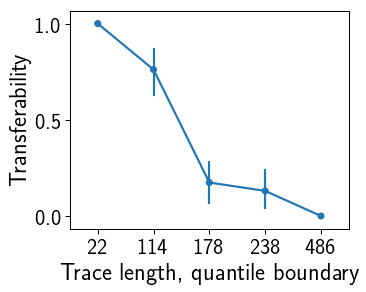

In [18]:
fig, ax = plt.subplots()

sns.pointplot(
    data=trans_df,
    x='qtracelen',
    y='svmpred',
    ax=ax
)

# plt.xticks(rotation='vertical')
ax.set_xticklabels(tracelen_quantiles)
ax.set_xlabel('Trace length, quantile boundary')
ax.set_ylabel('Transferability')

fig.set_figwidth(5)

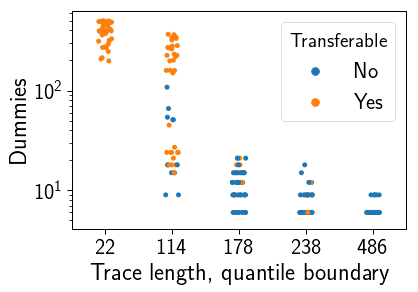

In [50]:
fig, ax = plt.subplots()

g = sns.stripplot(
    data=trans_df,
    x='qtracelen',
    y='realcost',
    hue='svmpred',
    ax=ax
)

g.legend_.set_title('Transferable')
g.legend_.texts[0].set_text('No')
g.legend_.texts[1].set_text('Yes')

ax.set_xticklabels(tracelen_quantiles)
ax.set_xlabel('Trace length, quantile boundary')
ax.set_ylabel('Dummies')

ax.set_yscale('log')

### Runtime and success rates

In [51]:
runtime_df = pd.DataFrame(columns=['eps', 'nodes', 'runtime', 'found'])

for eps, results_df in zip(EPSILONS, adv_results):
    for i, row in results_df.iterrows():
#         if row.found:
        runtime_df = runtime_df.append(
            {
                'eps': eps,
                'nodes': float(row.nodes_expanded),
                'runtime': float(row.runtime),
                'found': row.found
            },
            ignore_index=True)

Text(0,0.5,'Runtime, s')

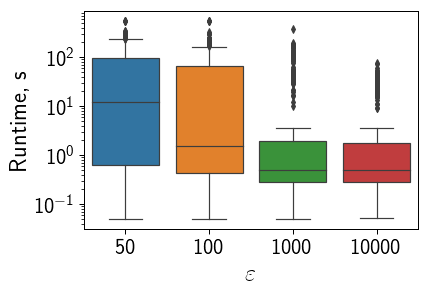

In [52]:
fig, ax = plt.subplots()

sns.boxplot(data=runtime_df, x='eps', y='runtime',
            ax=ax)

ax.set_yscale('log')
ax.set_xlabel(r'$\varepsilon$')
ax.set_ylabel('Runtime, s')

In [53]:
success_df = pd.DataFrame(columns=['eps', 'found', 'tracelen', 'realcost'])

for eps, results_df in zip(EPSILONS, adv_results):
    for i, row in results_df.iterrows():
        success_df = success_df.append({
            'eps': eps,
            'found': float(row.found),
            'tracelen': len(row.x),
            'realcost': float(row.real_cost) if row.found else None
        }, ignore_index=True)
        
success_df['qtracelen'] = pd.qcut(success_df.tracelen, 5)

Text(0.5,0,'$\\varepsilon$')

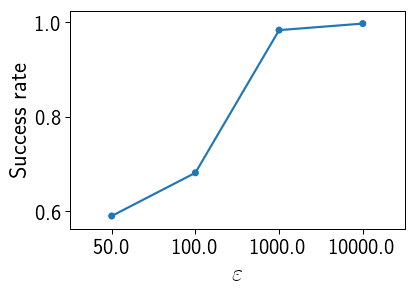

In [54]:
fig, ax = plt.subplots()

sns.pointplot(
    x=success_df.eps.unique(),
    y=success_df.groupby('eps').found.mean(),
    ax=ax)

ax.set_ylabel('Success rate')
ax.set_xlabel(r'$\varepsilon$')

Text(0,0.5,'Success rate')

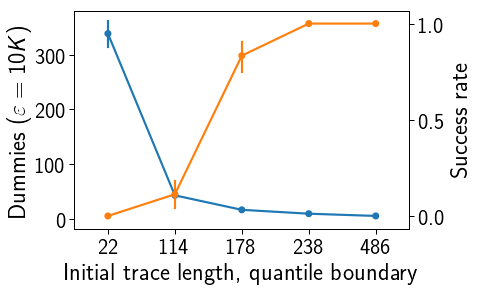

In [55]:
fig, ax = plt.subplots()

pal = sns.color_palette()

sns.pointplot(
    data=success_df.query('eps==10000'),
    x='qtracelen',
    y='realcost',
    color=pal[0],
    ax=ax)

ax2 = ax.twinx()

sns.pointplot(
    data=success_df.query('eps==50'),
    x='qtracelen',
    y='found',
    color=pal[1],
    ax=ax2,
)

ax.set_xticklabels(tracelen_quantiles)
ax.set_ylabel(r'Dummies ($\varepsilon = 10K$)')
ax.set_xlabel('Initial trace length, quantile boundary')

ax2.set_ylabel('Success rate')

### Cost overhead

In [56]:
costs_df = pd.DataFrame(columns=['eps', 'index', 'cost', 'overhead'])

smallest_eps_index = EPSILONS.index(min(EPSILONS))
baseline_df = adv_results[smallest_eps_index]

for eps, results_df in zip(EPSILONS, adv_results):
    for i, row in results_df.iterrows():
        if row.found:
            try:
                _, baseline_item = next(
                    baseline_df[baseline_df['index']==row['index']].iterrows())
            except:
                continue

            if baseline_item.found:
                overhead = row.path_cost / baseline_item['real_cost']
                costs_df = costs_df.append(
                    {'eps': eps, 'index': row['index'], 'cost': row['path_cost'], 'overhead': overhead},
                    ignore_index=True)

Text(0.5,0,'$\\varepsilon$')

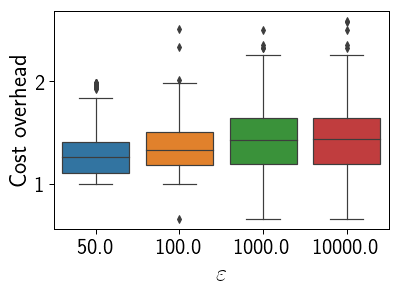

In [57]:
fig, ax = plt.subplots()

sns.boxplot(
    data=costs_df,
    x='eps',
    y='overhead',
    ax=ax
)

ax.set_ylabel('Cost overhead')
ax.set_xlabel(r'$\varepsilon$')